# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем необходимые библеотеки

In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import itertools
import operator
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
print(data.shape)
print()
print(data.info())
print()
data.head()

(10000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В столбце Tenure имеются пропуски. Проведем предобработку данных. 
Обработаем пропуски, заменим названия столбцов согласно правилу оформления, удалим столбцы которые нам не нужны, преобразуем колонки с категориальными данными в числовые по принципу OHE 

In [3]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [4]:
#Переименуем колонки
data.set_axis(['row_number',
             'customer_id', 
             'surname', 
             'credit_score', 
             'geography', 
             'gender', 
             'age', 
             'tenure', 
             'balance', 
             'products_num', 
             'has_cr_card', 
             'is_active', 
             'salary', 
             'exited'], axis=1, inplace=True)

In [5]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'products_num', 'has_cr_card',
       'is_active', 'salary', 'exited'],
      dtype='object')

In [6]:
#Удалим колонки row_number, customer_id, surname
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [7]:
#Заменим пропуски медианным значением, данные восстановить нет возможности
ten_medi = data['tenure'].median()
data['tenure'].fillna(ten_medi, inplace=True)
data['tenure'] = data['tenure'].astype('int64')

#print(data['tenure'].unique())

In [8]:
#Колонки с категориальными данными преобразуем в числовые по принципу OHE (one hot encoding)
data_ohe = pd.get_dummies(data, drop_first=True)

In [9]:
#Проверим данные на дубликаты

data.duplicated().sum()

0

In [10]:
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)

In [11]:
#Разобъем данные на обучающую, валидационную и тестовую выборки в соотношении 60/20/20

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345) 

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345) 

In [12]:
# Убедимся в правильности разделения датасета

print('Размер всего датасета:', data_ohe.shape)
print('Размер features_train:', features_train.shape)
print('Размер features_valid:', features_valid.shape)
print('Размер features_test:', features_test.shape)
print('Размер target_train:', target_train.shape)
print('Размер target_valid:', target_valid.shape)
print('Размер target_test:', target_test.shape)

Размер всего датасета: (10000, 12)
Размер features_train: (6000, 11)
Размер features_valid: (2000, 11)
Размер features_test: (2000, 11)
Размер target_train: (6000,)
Размер target_valid: (2000,)
Размер target_test: (2000,)


In [13]:
#Стандартизируем числовые вещественные данные

numeric = ['credit_score', 'age', 'tenure', 'balance', 'products_num', 'salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric]) 
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 

In [14]:
print(features_train.head())

      credit_score       age    tenure   balance  products_num  has_cr_card  \
7479     -0.886751 -0.373192  1.082277  1.232271     -0.891560            1   
3411      0.608663 -0.183385  1.082277  0.600563     -0.891560            0   
6027      2.052152  0.480939 -0.737696  1.027098      0.830152            0   
1247     -1.457915 -1.417129  0.354288 -1.233163      0.830152            1   
3716      0.130961 -1.132419 -1.101690  1.140475     -0.891560            0   

      is_active    salary  geography_Germany  geography_Spain  gender_Male  
7479          0 -0.187705                  0                1            1  
3411          0 -0.333945                  0                0            0  
6027          1  1.503095                  1                0            1  
1247          0 -1.071061                  0                0            1  
3716          0  1.524268                  1                0            0  


In [15]:
print(features_test.head())

      credit_score       age    tenure   balance  products_num  has_cr_card  \
7041     -2.226392 -0.088482 -1.101690 -1.233163      0.830152            1   
5709     -0.087120  0.006422  1.446272 -1.233163     -0.891560            1   
7117     -0.917905 -0.752805 -0.009707  0.722307     -0.891560            1   
7775     -0.253277  0.101325  1.810266 -1.233163      0.830152            1   
8735      0.785204 -0.847708  1.810266  0.615625     -0.891560            0   

      is_active    salary  geography_Germany  geography_Spain  gender_Male  
7041          0  0.647083                  0                0            1  
5709          0 -1.658410                  0                0            0  
7117          1 -1.369334                  0                1            1  
7775          0  0.075086                  0                1            1  
8735          1 -1.070919                  0                0            1  


Вывод:
Сделана предварительная замена значений признака 'tenure' (кол-во лет в банке), заменили на нулевые значения. Завышение значения кол-ва лет повышает кредитный рейтинг клиента, что влияет на надежность. Следовательно, чтобы минимизировать риски, пропущенные данные рекомендуется заменить на ноль.

Убрали из выборки колонки row_number, customer_id, surname, колонки с категориальными данными преобразовали в числовые по принципу OHE. Колонки с числовыми вещественными данными подвергли стандартизации.

## Исследование задачи

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   credit_score  10000 non-null  int64  
 1   geography     10000 non-null  object 
 2   gender        10000 non-null  object 
 3   age           10000 non-null  int64  
 4   tenure        10000 non-null  int64  
 5   balance       10000 non-null  float64
 6   products_num  10000 non-null  int64  
 7   has_cr_card   10000 non-null  int64  
 8   is_active     10000 non-null  int64  
 9   salary        10000 non-null  float64
 10  exited        10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [17]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  int64  
 3   balance            10000 non-null  float64
 4   products_num       10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active          10000 non-null  int64  
 7   salary             10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


In [18]:
#Проведем анализ баланса классов
best_model_dt = None
best_depth = 0
best_result = 0

for depth in range(1, 11):    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_result = result
        best_model_dt = model
        best_depth = depth
        
        
print('Лучший результат F1: \n\n', best_result,\
      '\n глубина:', best_depth)
print()
print(confusion_matrix(target_valid, predicted_valid))

Лучший результат F1: 

 0.5696969696969697 
 глубина: 6

[[1479  103]
 [ 226  192]]


In [19]:
print('Дисбаланс классов на тренировочной выборке =',\
      round(target_train[target_train==0].count()/target_train[target_train==1].count(),2))
print('Дисбаланс классов на тестовой выборке =',\
      round(target_test[target_test==0].count()/target_test[target_test==1].count(),2))
print('Дисбаланс классов =',\
      (target[target==0].count()/target[target==1].count()))

Дисбаланс классов на тренировочной выборке = 4.02
Дисбаланс классов на тестовой выборке = 3.73
Дисбаланс классов = 3.9091801669121256


In [20]:
#Расчитаем полноту и точность прогноза
recall_score(target_valid, predicted_valid)

0.45933014354066987

In [21]:
precision_score(target_valid, predicted_valid)

0.6508474576271186

In [22]:
probabilities_b = model.predict_proba(features_valid)
probabilities_one_valid_b = probabilities_b[:, 1]
auc_roc_b = roc_auc_score(target_valid, probabilities_one_valid_b)

print(auc_roc_b)

0.7657619511368929


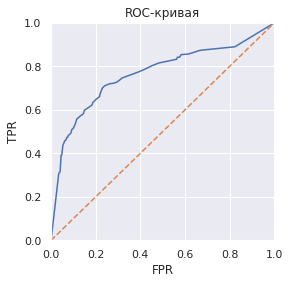

In [23]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_b) 

plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ROC-кривая")

plt.show()

F1 мера равна 0.569. Это значение ниже заданной минимальной - 0.59

Проведем обучение модели Случайного леса и подберем параметры

In [24]:
# Проведем исследование модели класса Случайный лес.
best_model_rf = None
best_depth = 0
best_result = 0
best_est = 0

for est in range(1, 50, 2):
    for depth in range(1, 50, 2):
    
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        probabilities_rf = model.predict_proba(features_valid)
        probabilities_one_valid_rf = probabilities_rf[:, 1]
        if result > best_result:
            best_result = result
            best_model_rf = model
            best_depth = depth
            best_est = est
                
print('Лучший результат f1: \n\n', \
      best_result, '\n глубина:', best_depth, '\n число деревьев', best_est)
print()
print('roc_auc_rf:', roc_auc_score(target_valid, probabilities_one_valid_rf))

Лучший результат f1: 

 0.5908419497784343 
 глубина: 7 
 число деревьев 5

roc_auc_rf: 0.8368230511919379


Для несбалансированной модели на алгоритме случайного леса максимальная метрика F1 наблюдается при глубине равной 7 и количестве деревьев 5 и составляет 0.590, что равно порогу 0.59

Проведем обучение модели Логистической регрессии 

In [25]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid_l = model.predict_proba(features_valid)
probabilities_one_valid_l = probabilities_valid_l[:, 1]

print('F1:', f1_score(target_valid, predicted_valid))
print('roc_auc_score:',roc_auc_score(target_valid, probabilities_one_valid_l))

F1: 0.33108108108108103
roc_auc_score: 0.7587512627102753


Метрика F1 на логистической регрессии равна 0.33, что значительно ниже порогового 0.59 и является наихудшим результатом

In [26]:
model = RandomForestClassifier(random_state=12345, n_estimators=5, max_depth=7)
model.fit(features_train, target_train)
probabilities_valid_u = model.predict_proba(features_valid)
probabilities_one_valid_u = probabilities_valid_u[:, 1]

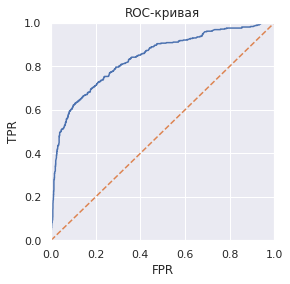

In [27]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_u) 

plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ROC-кривая")

plt.show()

In [28]:
roc_auc_score(target_valid, probabilities_one_valid_u)

0.8381787634815114

## Борьба с дисбалансом

In [29]:
#Воспользуемся методои upsampling для устранения дисбаланса классов в выборках
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


In [30]:
#Воспользуемся методом downsampling для устранения дисбаланса классов в выборках
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train, target_train, 0.39)

In [31]:
target[target == 0].count() / target[target == 1].count()

3.9091801669121256

Дисбаланс классов в целевом признаке кратен примерно 4

In [32]:
#Применим метод upsampling в Логистической регрессии 
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_lru = model.predict_proba(features_upsampled)
probabilities_one_valid_lru = probabilities_lru[:, 1]
auc_roc_lru = roc_auc_score(target_upsampled, probabilities_one_valid_lru)

print('roc_auc_score:', auc_roc_lru)
print("F1:", f1_score(target_valid, predicted_valid))

roc_auc_score: 0.7798911303011147
F1: 0.4888507718696398


In [33]:
#Применим метод downsampling в Логистической регрессии 
model = LogisticRegression(random_state=12345, solver='liblinear').fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
probabilities_lrd = model.predict_proba(features_downsampled)
probabilities_one_valid_lrd = probabilities_lrd[:, 1]
auc_roc_lrd = roc_auc_score(target_downsampled, probabilities_one_valid_lrd)

print('roc_auc_score:', auc_roc_lrd)
print("F1:", f1_score(target_valid, predicted_valid))

roc_auc_score: 0.7802658630868459
F1: 0.49946409431939987


In [34]:
#Добавим гиперпараметр class_weight='balanced'
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_lrb = model.predict_proba(features_valid)
probabilities_one_valid_lrb = probabilities_lrb[:, 1]
auc_roc_lrb = roc_auc_score(target_valid, probabilities_one_valid_lrb)

print('roc_auc_score:', auc_roc_lrb)
print('F1:', f1_score(target_valid, predicted_valid))

roc_auc_score: 0.7637310291013133
F1: 0.4888507718696398


F1 для сбалансированной модели на алгоритме логистической регрессии достигает максимального значения в 0.499 с использованием downsampled, что ниже порогового в 0.59.

In [35]:
#Случайный лес с upsampling
best_model_rfu = None
best_depth = 0
best_result = 0
best_est = 0

for est in range(10, 51, 10):
    for depth in range(1, 11):
    
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        probabilities_rfu = model.predict_proba(features_upsampled)
        probabilities_one_valid_rfu = probabilities_rfu[:, 1]
        auc_roc_rfu = roc_auc_score(target_upsampled, probabilities_one_valid_rfu)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_model_rfu = model
            best_depth = depth
            best_est = est
                
print('Лучший результат F1 модели Случайный лес: \n\n', \
      best_result, '\n глубина:', best_depth, '\n число деревьев', best_est)
print('roc_auc_score:', auc_roc_rfu)


Лучший результат F1 модели Случайный лес: 

 0.6239669421487604 
 глубина: 8 
 число деревьев 30
roc_auc_score: 0.974352998755218


In [36]:
#Случайный лес с downsampling
best_model_rfd = None
best_depth = 0
best_result = 0
best_est = 0

for est in range(10, 51, 10):
    for depth in range(1, 11):
    
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        probabilities_rfd = model.predict_proba(features_downsampled)
        probabilities_one_valid_rfd = probabilities_rfd[:, 1]
        auc_roc_rfd = roc_auc_score(target_downsampled, probabilities_one_valid_rfd)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_model_rfd = model
            best_depth = depth
            best_est = est
                
print('Лучший результат F1 модели Случайный лес: \n\n', \
      best_result, '\n глубина:', best_depth, '\n число деревьев', best_est)
print('roc_auc_score:', auc_roc_rfd)


Лучший результат F1 модели Случайный лес: 

 0.6270783847980999 
 глубина: 8 
 число деревьев 40
roc_auc_score: 0.9799951278362952


In [37]:
#Случайный лес с гиперпараметром class_weight='balanced'
best_model_rfb = None
best_depth = 0
best_result = 0
best_est = 0

for est in range(10, 51, 10):
    for depth in range(1, 11):
    
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_model_rfb = model
            best_depth = depth
            best_est = est
                
print('Лучший результат F1 модели Случайный лес: \n\n', \
      best_result, '\n глубина:', best_depth, '\n число деревьев', best_est)


Лучший результат F1 модели Случайный лес: 

 0.6236559139784946 
 глубина: 8 
 число деревьев 40


F1 для сбалансированной модели на алгоритме случайного леса достигает максимума 0.607 при применении гиперпараметра class_weight='balanced', что выше порогового в 0.59

In [38]:
#Дерево решений с upsampling
best_model_dt = None
best_depth = 0
best_result = 0

for depth in range(1, 11):    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predict_valid = model.predict(features_valid)
    probabilities_dtu = model.predict_proba(features_upsampled)
    probabilities_one_valid_dtu = probabilities_dtu[:, 1]
    auc_roc_dtu = roc_auc_score(target_upsampled, probabilities_one_valid_dtu)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_result = result
        best_model_dt = model
        best_depth = depth
        
        
print('Лучший результат f1 модели Дерево решений: \n\n', best_result,\
      '\n глубина:', best_depth)
print('roc_auc_score:', auc_roc_dtu)

Лучший результат f1 модели Дерево решений: 

 0.6140776699029126 
 глубина: 1
roc_auc_score: 0.9522696909487356


In [39]:
#Дерево решений с downsampling
best_model_dtd = None
best_depth = 0
best_result = 0

for depth in range(1, 11):    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predict_valid = model.predict(features_valid)
    probabilities_dtd = model.predict_proba(features_downsampled)
    probabilities_one_valid_dtd = probabilities_dtd[:, 1]
    auc_roc_dtd = roc_auc_score(target_downsampled, probabilities_one_valid_dtd)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_result = result
        best_model_dtd = model
        best_depth = depth
        
        
print('Лучший результат f1 модели Дерево решений: \n\n', best_result,\
      '\n глубина:', best_depth)
print('roc_auc_score:', auc_roc_dtd)

Лучший результат f1 модели Дерево решений: 

 0.6140776699029126 
 глубина: 1
roc_auc_score: 0.9587916230908435


In [40]:
#Дерево решений с гиперпараметром class_weight='balanced'
best_model_dtb = None
best_depth = 0
best_result = 0

for depth in range(1, 11):    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities_dtb = model.predict_proba(features_valid)
    probabilities_one_valid_dtb = probabilities_dtb[:, 1]
    auc_roc_dtb = roc_auc_score(target_valid, probabilities_one_valid_dtb)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_result = result
        best_model_dtd = model
        best_depth = depth
        
        
print('Лучший результат f1 модели Дерево решений: \n\n', best_result,\
      '\n глубина:', best_depth)
print('roc_auc_score:', auc_roc_dtb)


Лучший результат f1 модели Дерево решений: 

 0.5963791267305644 
 глубина: 5
roc_auc_score: 0.7512165873251109


F1, для сбалансированной модели на алгоритме дерева решений, достигает максимума 0.492 при применении downsampling, что ниже порогового в 0.59.

**Подбор параметров модели по обновленому сету данных**

In [41]:
best_model_rfb = None
best_depth = 0
best_result = 0
best_est = 0

for est in range(1, 50, 2):
    for depth in range(1, 50, 2):    
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_model_rfb = model
            best_depth = depth
            best_est = est
                
print('Лучший результат f1: \n\n', \
      best_result, '\n глубина:', best_depth, '\n число деревьев', best_est)

Лучший результат f1: 

 0.6288770053475936 
 глубина: 7 
 число деревьев 7


## Тестирование модели

Исследование моделей показало, что лучший результат метрики F1 достигается на сбалансированной методом class_weight='balanced' модели на алгоритме случайного леса.

После изменения дата сета, по которому была произведена балансировка и получены гиперпараметры лучшей модели по метрике F1 = 0.628 сделаем модель и проверим её

In [42]:
model = RandomForestClassifier(max_depth=7, n_estimators=7, class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6288770053475936


Проверим данный результат на тестовой выборке

In [43]:
predicted_test = model.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))

F1: 0.602308499475341


Получим AUC-ROC на валидационной выборке

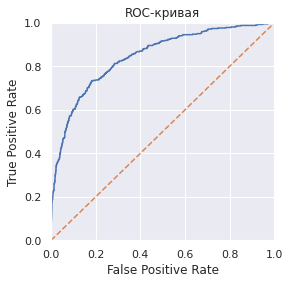

auc_roc = 0.8450974483975469


In [44]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one_test)
roc_a = roc_auc_score(target_test, probabilities_one_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure(figsize=(4, 4))

plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")

plt.show()
print('auc_roc =', roc_a)

**Выводы**
Имеем следующие показатели на выбранной обученной модели:

F1-мера: 0.628 (выше 0.59)
ROC AUC: 0.845
Таким образом поставленные цели достичь удалось.

***ОБЩИЙ ВЫВОД***

Входе проекта было рассмотрено и обучено несколько различных моделей. Наилучший результат показал RandomForestClassifier 
с подобранными к нему параметрами при помощи двойного цикла('max_depth': 7, 'n_estimators': 7), 
но обученная на новом датасете, к которому был применен параметр "class_weight='balanced'".

Первоначальный датасет был обработан и из него были убраны ненужные идентификаторы. Числовые данные были масштабированы. 

Значение меры f1=0.628 и 0.602 на тестовой модели, что превышает пороговое значение текущего проекта.
Метрика AUC-ROC=0.845.